In [1]:
%%capture

%load_ext autoreload
%autoreload 2
%matplotlib inline
%load_ext tfl_training_sbi

In [2]:
%presentation_style

In [3]:
%%capture

%set_random_seed 12

In [4]:
%load_latex_macros


$\newcommand{\vect}[1]{{\mathbf{\boldsymbol{#1}} }}$
$\newcommand{\amax}{{\text{argmax}}}$
$\newcommand{\P}{{\mathbb{P}}}$
$\newcommand{\E}{{\mathbb{E}}}$
$\newcommand{\R}{{\mathbb{R}}}$
$\newcommand{\Z}{{\mathbb{Z}}}$
$\newcommand{\N}{{\mathbb{N}}}$
$\newcommand{\C}{{\mathbb{C}}}$
$\newcommand{\abs}[1]{{ \left| #1 \right| }}$
$\newcommand{\simpl}[1]{{\Delta^{#1} }}$


<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">Include title and greeting with divs</div>

In [16]:
import math
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from tqdm.notebook import tqdm, trange
from torch.optim import Adam
from torch.utils.data import TensorDataset, DataLoader

from tfl_training_sbi import (
    mdn
)


# Conditional Density Estimation

_"In statistics, probability density estimation or simply density estimation is the construction of an **estimate, based on observed data**, of an unobservable underlying probability density function."_ (Wikipedia)

todo: why do we want to do it, i.e. motivation; what will be covered

## Density Estimation 

Given samples $\theta_i,~i=1,\dots,n$ with $\theta_i \sim p(\theta)$ but $p(\theta)$ **unknown**.

Goal: find $\hat{p}(\theta) \approx p(\theta)$.
<figure>
  <center>
  <img src=_static/images/density_est_species.png style="width:45%"/>
    <figcaption>Fig.1 - Plot from <a href"https://scikit-learn.org/stable/auto_examples/neighbors/plot_species_kde.html">scikit-learn</a></figcaption>
</figure>

## Methods for Density Estimation

- Histograms
- Kernel density estimation 
- Non-parametric approaches 
- Neural networks (VAEs, GANs, Normalizing Flows, ...)

## Example: Likelihood Estimation

Given observations $\theta_i,~i=1,\dots,n$, find $\hat{p}(\theta)$

- Assumption: Data follows Normal distribution 
- Maximize Likelihood of $\theta_i$ under $\hat{p}$
- Find $\mu, \sigma$ where $\hat{p} := \mathcal{N}(\mu, \sigma)$

$$
\mu^{\prime}, \sigma^{\prime} = \underset{\mu, \sigma}{\operatorname{argmin}} - \sum_i^n \log \mathcal{N}(\theta_i; \mu, \sigma)
$$

<figure>
    <center>
    <img src="_static/images/density_est_toy_example_gauss.png" style="width:50%"/>
    <figcaption>Fig. 2 - Figure taken from <a href="https://mlcolab.org/simulation-based-inference-for-scientific-discovery">MLColab</a></figcaption>
</figure>

## Conditional Density Estimation

Target is conditioned on a random variable: $p(\theta) \longrightarrow p(x \mid \theta)$

Goal: density estimate for $x$ **given** an observation $\theta^{\prime}$, e.g.

$$
p(\text{drop=off} \mid \text{pick-up}=\theta) = p(x \mid \theta)
$$

<figure>
    <center>
    <img src="_static/images/taxi.png" style="width:50%"/>
    <figcaption>Fig. 3 - Figure taken from <a href="https://mlcolab.org/simulation-based-inference-for-scientific-discovery">MLColab</a></figcaption>
</figure>

## Parametric Conditional Density Estimation

Given a fixed value $\theta$, parameterize a probability density over data $x$.
E.g. compute the conditional mean and variance of a Gaussian distribution using a function $f(\theta)$.

$$
p(x \mid \theta) = \mathcal{N}(x; \mu(\theta), \sigma(\theta))
$$

Note, $f$ can be any function, e.g. a neural network.

Estimate the distribution parameters $\mu(\theta), \sigma(\theta)$ of

$$
p(x \mid \mu(\theta), \sigma(\theta)) = \frac{1}{\sqrt{2\pi\sigma^2}}\exp(-\frac{(x-\mu(\theta))^2}{2\sigma^2(\theta)})
$$

by minimizing the negative log-Likelihood of the data under the model.

$$
\mathcal{L}(x, \theta) = - \sum_i \log \mathcal{N}(x_i; \mu(\theta_i), \sigma(\theta_i))
$$

Note, this is closely related to Bayesian linear regression.

## Example: Parametric Conditional Density Estimation

Given observations $x = \theta + 0.3\sin(2 \pi \theta) + \epsilon$ with $\theta
\sim \mathcal{U}(0,1)$ and $\epsilon \sim \mathcal{N}(0, 0.05)$.

Approximate $p(x \mid \theta = 0.1)$.

<figure>
    <center>
    <img src="_static/images/cde_gaussian.png" style="width:50%"/>
    <figcaption>Fig. 4 - Conditional density estimation with parametric Gaussian. Figure taken from <a href="https://mlcolab.org/simulation-based-inference-for-scientific-discovery">MLColab</a></figcaption>
</figure>

## Create  the Dataset 

In [6]:
sample_size = 1000
dim = 1

theta = torch.rand((sample_size, dim))
noise = torch.rand((sample_size, dim)) * 0.2

x = theta + 0.3 * torch.sin(2 * math.pi * theta) + noise


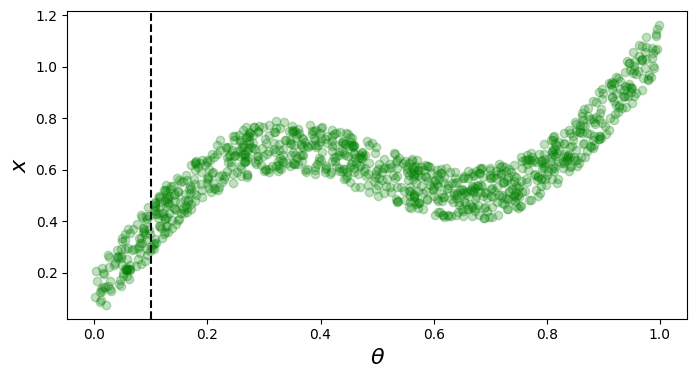

In [7]:
plt.figure(figsize=(8, 4))
plt.plot(theta, x, "go", alpha=0.25)
plt.axvline(0.1, color="black", linestyle="--")
plt.ylabel("$x$", fontsize=16)
plt.xlabel("$\\theta$", fontsize=16)
plt.show()


In [11]:
dataset = TensorDataset(theta, x)
train_loader = DataLoader(dataset, batch_size=20)

# define a simple neural network to parameterize the conditional density
net = nn.Sequential(
    nn.Linear(1, 20), nn.ReLU(), nn.Linear(20, 20), nn.ReLU(), nn.Linear(20, 2)
)

opt = Adam(net.parameters(), lr=0.001)

# train the neural network for 100 epochs
for e in trange(100):
    for theta_batch, x_batch in train_loader:
        opt.zero_grad()
        nn_output = net(theta_batch)
        mean = nn_output[:, 0].unsqueeze(1)
        std = torch.exp(nn_output[:, 1]).unsqueeze(1)
        prob_Gauss = (
            1
            / torch.sqrt(2 * math.pi * std**2)
            * torch.exp(-0.5 / std**2 * (mean - x_batch) ** 2)
        )
        loss = -torch.log(prob_Gauss).sum()
        loss.backward()
        opt.step()


  0%|          | 0/100 [00:00<?, ?it/s]

## Inspecting the Learned Distribution


In [9]:
theta_cond = torch.Tensor([0.1])
estimated_params = net(theta_cond)

cond_mean, cond_std = (
    estimated_params[0].detach().numpy(),
    torch.exp(estimated_params[1]).detach().numpy(),
)

print(f"Estimated mean: {cond_mean:.3f} and sigma: {cond_std:.3f}")


Estimated mean: 0.371 and sigma: 0.060


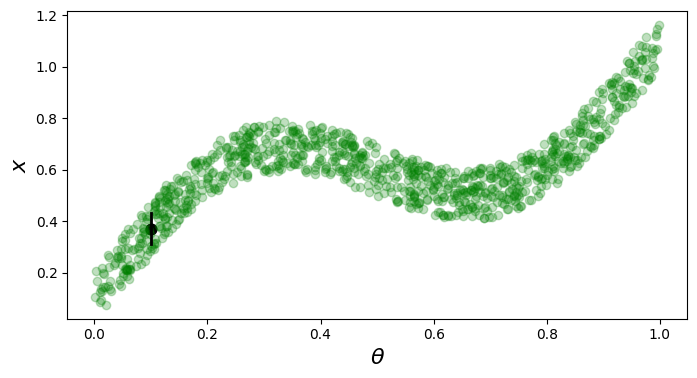

In [14]:
plt.figure(figsize=(8, 4))

plt.plot(theta, x, "go", alpha=0.25)
plt.plot(
    [theta_cond[0], theta_cond[0]],
    [cond_mean - cond_std, cond_mean + cond_std],
    "k-",
    linewidth=2,
)
plt.scatter(theta_cond[0], cond_mean, c="k", s=60)

plt.ylabel("$x$", fontsize=16)
plt.xlabel("$\\theta$", fontsize=16)

plt.show()


In [15]:
# todo: eval. the density est. for all thetas to show that it is a good fit

## The Problem in the Approach

- The density model is **too simple** to capture the true distribution
- Realistic distributions are more complex than a single Gaussian

## Mixture Density Networks

Instead of a single Gaussian, a linear combination of $k$ Gaussians is used. Each
Gaussian distribution can be parameterized. 

\begin{align}
\mathcal{L} &= - \sum_{i=1} \log q(\theta_i \mid x_i) \\
 &= - \sum_{i=1} \log \sum_{j=1}^k \alpha_j \mathcal{N}(\theta_i; \mu_j(x_i), \sigma_j(x_i))
\end{align}

The mixture weights $\alpha_j$, means $\mu_j$ and (co-)variances $\sigma_j$ are
learned. 

<img src="_static/images/aai-institute-cover.svg" alt="Snow" style="width:100%;">
<div class="md-slide title">Thank you for the attention!</div>